# Import libraries

In [2]:
drive_path = '/Volumes/Brain2016'
# We need to import these modules to get started
import numpy as np
import pandas as pd
import os
import sys
from scipy.stats.stats import pearsonr
import matplotlib.pyplot as plt
%matplotlib notebook
from allensdk.core.brain_observatory_cache import BrainObservatoryCache
import seaborn
import time as tm

manifest_path = os.path.join(drive_path,'BrainObservatory','manifest.json')
boc = BrainObservatoryCache(manifest_file=manifest_path)

In [2]:
expMetaData = pd.DataFrame(boc.get_ophys_experiments())
expMetaData.head()

,age_days,cre_line,experiment_container_id,id,imaging_depth,session_type,targeted_structure
0,132.0,Cux2-CreERT2,511510753,502066273,175,three_session_C,VISpm
1,116.0,Rorb-IRES2-Cre,511511001,506278598,275,three_session_B,VISpm
2,97.0,Rbp4-Cre,511510653,510529677,375,three_session_A,VISpm
3,116.0,Rorb-IRES2-Cre,511510729,504614224,275,three_session_C,VISl
4,123.0,Rorb-IRES2-Cre,511507144,501724959,275,three_session_A,VISp


# Plot run speed, motion correction, delF/F_0 

<IPython.core.display.Javascript object>


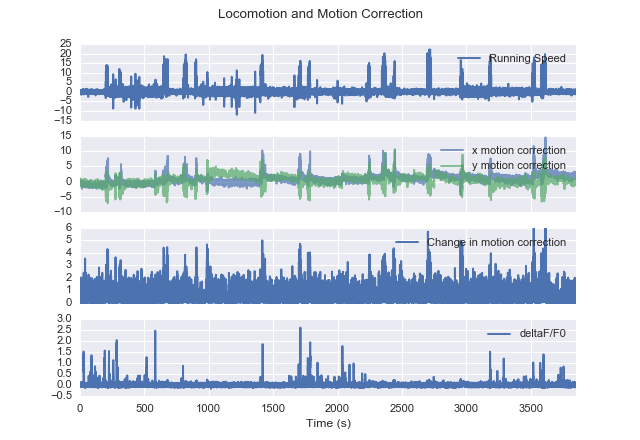

/Users/bilalbari/anaconda/lib/python2.7/site-packages/pandas/core/internals.py:227: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 115730 but corresponding boolean dimension is 115729
  return self.values[slicer]
/Users/bilalbari/anaconda/lib/python2.7/site-packages/pandas/indexes/base.py:1275: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 115730 but corresponding boolean dimension is 115729
  result = getitem(key)


In [3]:
expContainerID = 501940850
exp = boc.get_ophys_experiment_data(ophys_experiment_id = expContainerID)
rSpd, t_rSpd = exp.get_running_speed()
motion = exp.get_motion_correction()
_, dF = exp.get_dff_traces()

motion_hyp = abs(np.diff(motion.x_motion)) + abs(np.diff(motion.y_motion))
rSpd = rSpd[1:]
dF = dF[:,1:]
nanMask = ~np.isnan(rSpd)
time = np.arange(len(rSpd))/float(30)

fig, axes = plt.subplots(nrows=4, ncols=1, sharex=True)
axes[0].plot(time[nanMask],rSpd[nanMask], label='Running Speed'); 
axes[1].plot(time[nanMask],motion.x_motion[nanMask], label='x motion correction', alpha = 0.7) 
axes[1].plot(time[nanMask],motion.y_motion[nanMask], label='y motion correction', alpha = 0.7)
axes[2].plot(time[nanMask],motion_hyp[nanMask], label='Change in motion correction'); 
axes[2].set_ylim([-.1, 6])
axes[3].plot(time[nanMask],dF[5][nanMask], label='deltaF/F0'); axes[3].legend(loc='upper right', fontsize = 10)
axes[3].set_xlabel('Time (s)')

for ax in axes:
    ax.legend(loc='upper right', fontsize = 10)
    ax.set_xlim(0, time[nanMask][-1])
fig.suptitle('Locomotion and Motion Correction')

## Session-by-session motion correction vs locomotion

In [5]:
allPear = []
totRunTime = 0;
totTime = 0;
for expContainerID in expMetaData.id[26:27]:
    exp = boc.get_ophys_experiment_data(ophys_experiment_id = expContainerID)
    rSpd, _ = exp.get_running_speed()
    motion = exp.get_motion_correction()
    motion_hyp = abs(np.diff(motion.x_motion)) + abs(np.diff(motion.y_motion))
    
    rSpd = rSpd[1:]
    nanMask = ~np.isnan(rSpd)
    
    tmp, b = pearsonr(rSpd[nanMask],motion_hyp[nanMask])
    allPear.append(tmp)
    
    totRunTime += len(rSpd[rSpd > 1])
    totTime += len(rSpd)

In [6]:
mTmp = np.sqrt(motion.x_motion[nanMask]**2 + motion.y_motion[nanMask]**2)
rTmp = abs(rSpd[nanMask])

876.876383417
[0]


<IPython.core.display.Javascript object>


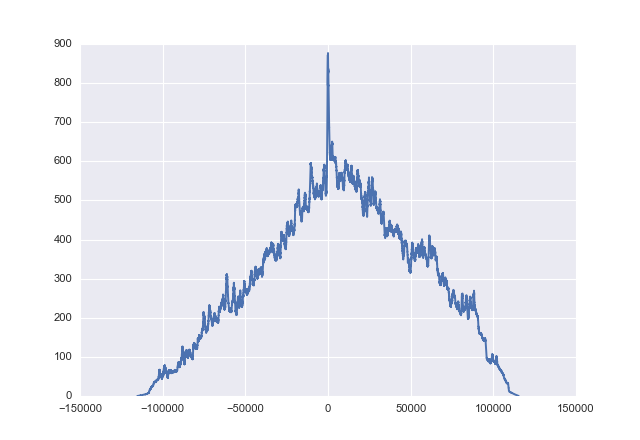

In [7]:
xCor = np.correlate(mTmp[91:]/max(mTmp[91:]), rTmp[:-91]/max(rTmp[:-91]),'full')
time = np.arange(len(xCor))-len(xCor)/2

print(max(xCor))
print(time[np.where(xCor == max(xCor))])
plt.figure()
plt.plot(time, xCor)

<IPython.core.display.Javascript object>


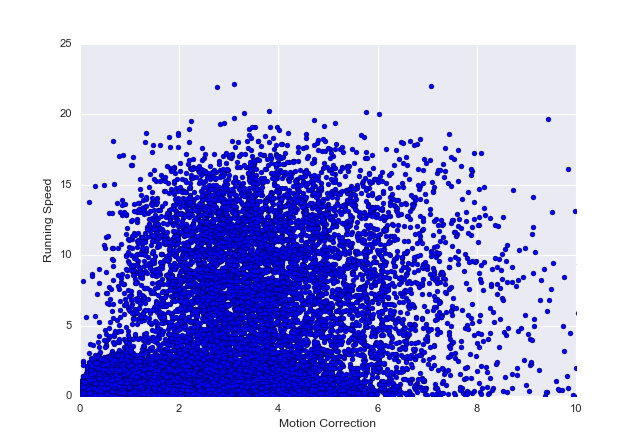

(0.37066366740203482, 0.0)


In [8]:
fig,ax = plt.subplots()
ax.scatter(mTmp[91:], rTmp[:-91])
ax.set_xlabel('Motion Correction')
ax.set_ylabel('Running Speed')
ax.set_xlim(0, 10)
ax.set_ylim(0, 25)

print(pearsonr(mTmp[:-6], abs(rTmp[6:])))

## Locomotion-triggered $\Delta$F/F$_0$

In [6]:
# expContainerID = expMetaData.id[0]
expContainerID = 501940850
exp = boc.get_ophys_experiment_data(ophys_experiment_id = expContainerID)
rSpd, t_rSpd = exp.get_running_speed()
motion = exp.get_motion_correction()
t_dF, dF = exp.get_dff_traces()

nanMask = ~np.isnan(rSpd)

<IPython.core.display.Javascript object>


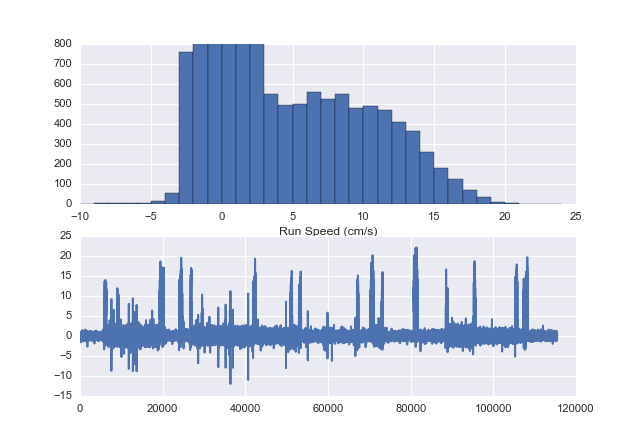

In [4]:
fig,ax = plt.subplots(nrows = 2)
ax[0].hist(rSpd[nanMask],bins = np.arange(-10,25))
ax[0].set_ylim(0,800)

ax[1].plot(rSpd[nanMask])
# ax.set_xlim(left = 0)
ax[0].set_xlabel('Run Speed (cm/s)')

In [106]:
runStart = np.where(rSpd[nanMask] > 5); runStart = runStart[0];

allRunsFound = False
firstInd = 0
secondInd = 1
runBouts = []
while ~allRunsFound:
    if secondInd == len(runStart):
        allRunsFound = True
        break
#     print(runStart[firstInd], runStart[secondInd], runStart[secondInd]-runStart[firstInd])
    if (runStart[secondInd] - runStart[firstInd]) <= 30:
        secondInd += 1
    elif (runStart[secondInd] - runStart[firstInd]) <= 60:
        runBouts.append(runStart[firstInd])
        firstInd = secondInd
        secondInd += 1
    else:
        firstInd = secondInd
        secondInd += 1


In [8]:
runStart = np.where(rSpd[nanMask] > 5); runStart = runStart[0];
rSpd = abs(rSpd)

firstInd = 0
secondInd = 1
iterInd1 = 0
iterInd2 = 0
runBouts = []
while secondInd < len(runStart):
    runEndFound = False
    if (runStart[secondInd] - runStart[firstInd]) <= 30: # run lengths < 1s long
        secondInd += 1
    elif (runStart[secondInd] - runStart[firstInd]) <= 60: # an appropriately long run bout
        iterInd1 = secondInd
        iterInd2 = iterInd1 + 1
        while ~runEndFound:
            if iterInd2 == len(runStart):
                runEndFound = True
                secondInd = iterInd2 + 1
                break
            if (runStart[iterInd2] - runStart[iterInd1]) <= 30:
                iterInd2 += 1
            elif (runStart[iterInd2] - runStart[iterInd1]) <= 60:
                iterInd1 = iterInd2 - 1
                iterInd2 += 1
            else:
                runEndFound = True
                runBouts.append(runStart[firstInd])
                firstInd = iterInd2
                secondInd = iterInd2 + 1
                break
    else:
        firstInd = secondInd 
        secondInd += 1

In [6]:
len(runBouts)

24

<IPython.core.display.Javascript object>


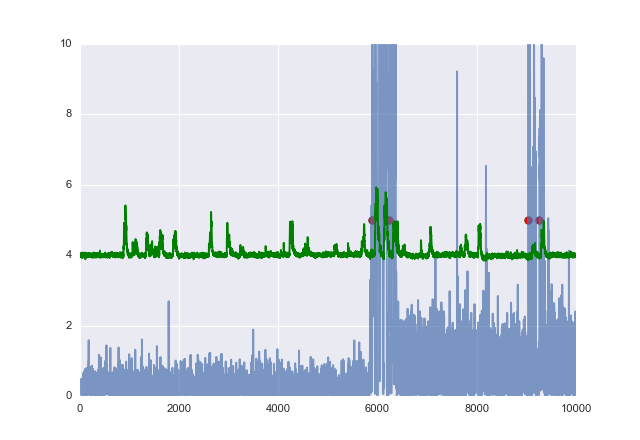

(0, 10)

In [41]:
fig,ax = plt.subplots()

ax.plot(rSpd[nanMask],alpha = 0.7)
ax.scatter(runBouts,np.ones(len(runBouts))*5,s=50,c='red')
ax.plot(dF[16][nanMask]+4,c='green')
ax.set_xlim(0, 10000)
ax.set_ylim(0, 10)

<IPython.core.display.Javascript object>


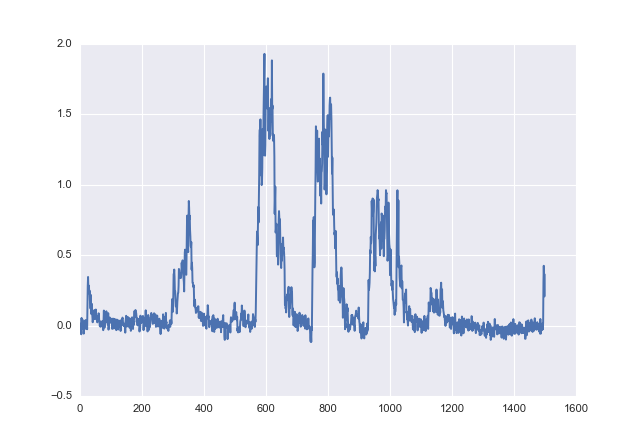

In [42]:
plt.figure()
plt.plot(dF[16][nanMask][runBouts[0]-500:runBouts[0]+1000])

In [219]:
data = np.random.rand(100,3)
columns = ['cell_1','cell_2','cell_3']
df_arr = pd.DataFrame(data,columns=columns)
df_arr['cell_4'] = ''
df_arr.loc[1,['cell_4']] = 1
df_arr

,cell_1,cell_2,cell_3,cell_4
0,0.429868,0.101610,0.608583,
1,0.568765,0.477338,0.464551,1
2,0.819631,0.109983,0.222465,
3,0.658243,0.023236,0.381304,
4,0.498497,0.715670,0.201725,
5,0.481739,0.474638,0.894201,
6,0.692361,0.973081,0.301132,
7,0.980341,0.175654,0.555104,
8,0.232239,0.687142,0.677565,
9,0.832267,0.158844,0.932069,


In [43]:
locDF = pd.DataFrame(index=np.arange(len(runBouts)),columns=np.arange(dF.shape[0]))
for cell in range(dF.shape[0]):
    for locOnset in runBouts:
        locDF.loc[np.where(runBouts == locOnset)[0][0],cell] = dF[cell][nanMask][locOnset-60:locOnset+60]

<IPython.core.display.Javascript object>


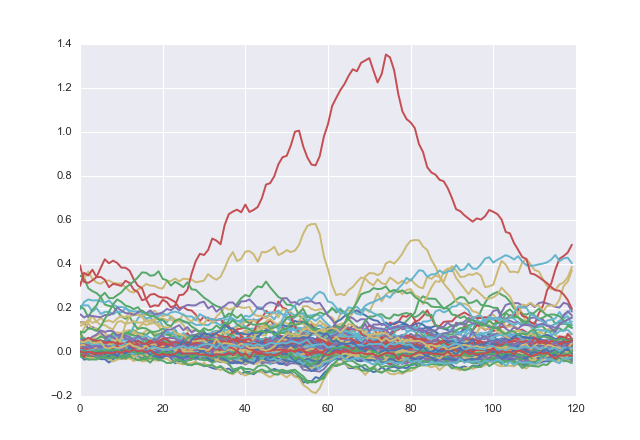

In [45]:
plt.figure()
for j in range(locDF.shape[1]):
    plt.plot(locDF.loc[:,j].mean())
#     plt.clf()


# plt.plot(locDF.stack().mean())

TypeError: Invalid dimensions for image data

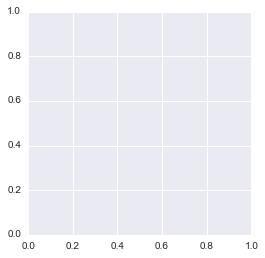

In [15]:
# plt.figure()
plt.imshow(locDF.loc[:,j].mean())

In [ ]:
locDF.loc[:,j].mean()